In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scipy.io as sio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import hdc

import importlib
importlib.reload(hdc)

%matplotlib notebook

In [2]:
# location of all offline data
dataDir = './emg_mat/offline/'

baseExperiment = 1
newExperiment = 3

holdStart = 70
holdEnd = 149
D = 10000
numFeat = 320
numEx = holdEnd - holdStart + 1

numIter = 1

numSVM = np.zeros((5,20,numIter))
accSVM = np.zeros((5,20,numIter))
numHDC = np.zeros((5,20,numIter))
accHDC = np.zeros((5,20,numIter))

# for s in range(5):
for s in [1]:
    # subject labels are 1-indexed
    subject = s + 1
    print('Gathering data for Subject ' + str(subject))
    
    # load data from the two contexts
    filename = dataDir + 'S' + str(subject) + 'E' + str(baseExperiment) + '.mat'
    base = sio.loadmat(filename)['emgHD']
    filename = dataDir + 'S' + str(subject) + 'E' + str(newExperiment) + '.mat'
    new = sio.loadmat(filename)['emgHD']
    
    # get metatdata
    numGest, numTrial = base.shape
    numCh = base[0,0][2].shape[1]
    
    # separate training and testing dataframes
    features = np.empty((numCh*5,0))
    ngrams = np.empty((D,0))
    labels = np.empty(0)
    trials = np.empty(0)
    context = np.empty(0)

    # collect baseline data
    for g in range(numGest):
        for t in range(numTrial):
            trial = base[g,t]
            feat = np.empty((0,numEx))
            for i in range(5):
                feat = np.concatenate((feat,trial[2][(holdStart+i):(holdEnd+i+1),:].T),axis=0)
            features = np.concatenate((features,feat),axis=1)
            ngrams = np.concatenate((ngrams,trial[3][:,holdStart:holdEnd+1]),axis=1)
            labels = np.concatenate((labels,g*np.ones(numEx)))
            trials = np.concatenate((trials,t*np.ones(numEx)))
            context = np.concatenate((context,0*np.ones(numEx)))
    
    # collect new data
    for g in range(numGest):
        for t in range(numTrial):
            trial = new[g,t]
            feat = np.empty((0,numEx))
            for i in range(5):
                feat = np.concatenate((feat,trial[2][(holdStart+i):(holdEnd+i+1),:].T),axis=0)
            features = np.concatenate((features,feat),axis=1)
            ngrams = np.concatenate((ngrams,trial[3][:,holdStart:holdEnd+1]),axis=1)
            labels = np.concatenate((labels,g*np.ones(numEx)))
            trials = np.concatenate((trials,t*np.ones(numEx)))
            context = np.concatenate((context,1*np.ones(numEx)))

    # create dataframe for features
    featCols = ['feature' + str(i) for i in range(features.shape[0])]
    featData = pd.DataFrame(features.T,columns=featCols)
    featData['gesture'] = labels
    featData['trial'] = trials
    featData['context'] = context

    # create dataframe for ngrams
    ngramCols = ['hv' + str(i) for i in range(ngrams.shape[0])]
    ngramData = pd.DataFrame(ngrams.T,columns=ngramCols)
    ngramData['gesture'] = labels
    ngramData['trial'] = trials
    ngramData['context'] = context
    
    testPercentage = np.linspace(0.05,1,20)
    for tpIdx,tp in enumerate(testPercentage):
        print('Running with %f of trial for training' % (tp))
        # iterate through to get averages (cross-validation)
        for n in range(numIter):
            isTest = np.empty(0)
            testTrials = np.random.randint(0,numTrial,numGest)
            for g in range(numGest):
                for t in range(numTrial):
                    if t == testTrials[g]:
                        isTest = np.concatenate((isTest,np.random.permutation(np.concatenate((np.ones(int(round(tp*numEx))), -np.ones(numEx - int(round(tp*numEx))))))))
                    else:
                        isTest = np.concatenate((isTest,np.zeros(numEx)))
            testTrials = np.random.randint(0,numTrial,numGest)
            for g in range(numGest):
                for t in range(numTrial):
                    if t == testTrials[g]:
                        isTest = np.concatenate((isTest,np.random.permutation(np.concatenate((np.ones(int(round(tp*numEx))), -np.ones(numEx - int(round(tp*numEx))))))))
                    else:
                        isTest = np.concatenate((isTest,np.zeros(numEx)))

            featData['isTest'] = isTest
            ngramData['isTest'] = isTest

            # train HD model
            allGest = ngramData['gesture'].unique()
            AM = hdc.Memory(D)
            for g in allGest:
    #             ng = np.asarray(ngramData.loc[(ngramData['gesture'] == g) & (ngramData['isTest'] == 0) & (ngramData['context'] == 0)].iloc[:,0:D])
                ng = np.asarray(ngramData.loc[(ngramData['gesture'] == g) & (ngramData['isTest'] == 1) & (ngramData['context'] == 0)].iloc[:,0:D])
                AM.train(ng,vClass=g,vClust=0)
#                 AM.train_sub_cluster(ng,vClass=g)

            for g in allGest:
    #             ng = np.asarray(ngramData.loc[(ngramData['gesture'] == g) & (ngramData['isTest'] == 0) & (ngramData['context'] == 1)].iloc[:,0:D])
                ng = np.asarray(ngramData.loc[(ngramData['gesture'] == g) & (ngramData['isTest'] == 1) & (ngramData['context'] == 1)].iloc[:,0:D])
#                 AM.train(ng,vClass=g,vClust=1)
                AM.train_sub_cluster(ng,vClass=g)

            # collect testing data and perform inference
            testNgram = ngramData.loc[(ngramData['isTest'] == 0)].iloc[:,0:D]
            testLabel = ngramData.loc[(ngramData['isTest'] == 0)].iloc[:,D]

            label,sim = AM.match(np.asarray(testNgram),bipolar=True)
            accHDC[s,tpIdx,n] = (label == np.asarray(testLabel)).sum()/len(label)
            numHDC[s,tpIdx,n] = len(AM.classes)
#             acc = accHDC[s,tpIdx,np.nonzero(accHDC[s,tpIdx,:])].mean()
#             print('\t HDC Iteration %d: Accuracy = %f'%(n+1,acc))

            # train and test SVM model
            clf = svm.SVC(decision_function_shape='ovo',kernel='linear',C=1)
    #         clf.fit(featData.loc[featData['isTest'] == 0].iloc[:,0:numFeat],featData.loc[featData['isTest'] == 0].iloc[:,numFeat])
            clf.fit(featData.loc[featData['isTest'] == 1].iloc[:,0:numFeat],featData.loc[featData['isTest'] == 1].iloc[:,numFeat])
    #         yhat = clf.predict(featData.loc[featData['isTest'] == 1].iloc[:,0:numFeat])
    #         accSVM[s,n] = accuracy_score(yhat,featData.loc[featData['isTest'] == 1].iloc[:,numFeat])
            yhat = clf.predict(featData.loc[featData['isTest'] == 0].iloc[:,0:numFeat])
            accSVM[s,tpIdx,n] = accuracy_score(yhat,featData.loc[featData['isTest'] == 0].iloc[:,numFeat])
            numSVM[s,tpIdx,n] = len(clf.support_)
#             acc = accSVM[s,tpIdx,np.nonzero(accSVM[s,tpIdx,:])].mean()
#             num = numSVM[s,tpIdx,np.nonzero(numSVM[s,tpIdx,:])].mean()
#             print('\t Iteration %d: SVM Accuracy = %f'%(n+1,acc))

            print('Finished iteration %d\r' % (n), end="")
        print('')
        

Gathering data for Subject 2
Running with 0.050000 of trial for training
Finished iteration 0
Running with 0.100000 of trial for training
Finished iteration 0
Running with 0.150000 of trial for training
Finished iteration 0
Running with 0.200000 of trial for training
Finished iteration 0
Running with 0.250000 of trial for training
Finished iteration 0
Running with 0.300000 of trial for training
Finished iteration 0
Running with 0.350000 of trial for training
Finished iteration 0
Running with 0.400000 of trial for training
Finished iteration 0
Running with 0.450000 of trial for training
Finished iteration 0
Running with 0.500000 of trial for training
Finished iteration 0
Running with 0.550000 of trial for training
Finished iteration 0
Running with 0.600000 of trial for training
Finished iteration 0
Running with 0.650000 of trial for training
Finished iteration 0
Running with 0.700000 of trial for training
Finished iteration 0
Running with 0.750000 of trial for training
Finished iteratio

<IPython.core.display.Javascript object>


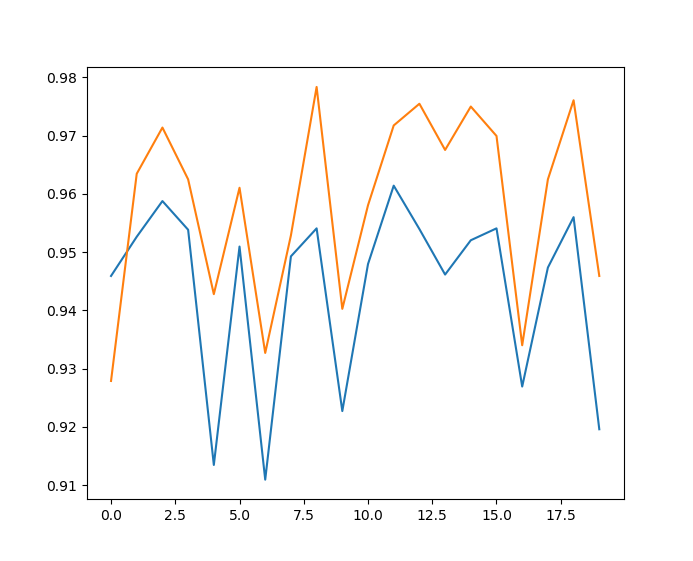

In [3]:
plt.plot(accHDC[1,:,:])
plt.plot(accSVM[1,:,:])

In [4]:
len(AM.classes)

630